In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../../WobbleSim')
import simulacra.dataset
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np

from IPython.display import Video

import jabble.dataset
import jabble.loss
import jabble.model
import os

import matplotlib.pyplot as plt
from matplotlib import cm

<h1>32 - Take data from MANY straight flying star</h1>

In [2]:
# import cv2

In [3]:
from datetime import datetime
import os
date = datetime.today().strftime('%Y-%m-%d')
outdir = os.path.join('/scratch/mdd423/wobble_jax/out/',date)
os.makedirs(outdir,exist_ok=True)

In [4]:
import glob
files = glob.glob('/scratch/mdd423/simulacra/out/2022-04-04/data_*')
# import os
# mypath = '/scratch/mdd423/simulacra/out/2022-03-07/'
# files = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f)) and "8.3e+03" in f]

In [5]:
files

['/scratch/mdd423/simulacra/out/2022-04-04/data_e30_R130000.0_a10.0_p30.0_l7.0e+037.4e+03_snr50.0.h5',
 '/scratch/mdd423/simulacra/out/2022-04-04/data_e30_R130000.0_a10.0_p30.0_l7.0e+037.4e+03_snr150.0.h5',
 '/scratch/mdd423/simulacra/out/2022-04-04/data_e30_R130000.0_a10.0_p30.0_l7.0e+037.4e+03_snr200.0.h5',
 '/scratch/mdd423/simulacra/out/2022-04-04/data_e30_R130000.0_a10.0_p30.0_l7.0e+037.4e+03_snr250.0.h5',
 '/scratch/mdd423/simulacra/out/2022-04-04/data_e30_R130000.0_a10.0_p30.0_l7.0e+037.4e+03_snr100.0.h5']

In [6]:
import scipy.ndimage
def normalize(y,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y_low

In [7]:
datasets = []
h5_data = []
snrs = []
for file in files:
    data    = simulacra.dataset.from_h5(file)
    h5_data.append(data)
    epoches = data['data']['flux'].shape[0]

    wave = np.repeat(np.array(data['data']['wave'])[np.newaxis,:],epoches,axis=0) * u.Angstrom
    flux = np.array(data['data']['flux'])
    ferr = np.array(data['data']['ferr'])

    masks = np.array(data['data']['mask'],dtype=bool)
    masks = np.logical_or(np.isnan(ferr), masks)
    masks = np.logical_or(np.isnan(flux), masks)
    masks = np.logical_or(flux <= 0, masks)

    sigma = 400
    dataset = jabble.dataset.Dataset.from_flux(wave,flux,ferr,masks,normalize,nargs=[sigma])
    dataset.set_mask(0.0,10.0)
    
    datasets.append(dataset)

    obs_times = data['data']['obs_times']
    times = at.Time(obs_times)

    loc    = data['parameters']['detector']['loc']
    target = data['parameters']['star']['target']
    resolution = float(data['parameters']['detector']['_resolution'][()])

    bc = target.radial_velocity_correction(obstime=times[-1],location=loc).to(u.km/u.s)
    rv = data['data']['rvs'].to(u.km/u.s)
    snr = np.mean(data['data']['snr_readout'][~np.isnan(data['data']['snr_readout'])])
    snrs.append(snr)
    print(snr)

<HDF5 dataset "obs_times": shape (30,), type "|O">
50.05548424849834
<HDF5 dataset "obs_times": shape (30,), type "|O">
150.1721987351096
<HDF5 dataset "obs_times": shape (30,), type "|O">
200.22915494761546
<HDF5 dataset "obs_times": shape (30,), type "|O">
250.28677301557755
<HDF5 dataset "obs_times": shape (30,), type "|O">
100.1147974094772


<h2>Load Data</h2>
Load in the datasets and normalize it using a gaussian filter. And take a look at slices of each dataset. Each dataset read in has a different average SNR across all epoches. We will fit a model to each dataset and compare the accuracy of the radial velocity as function of this SNR.

In [8]:
len(h5_data)

5

In [9]:
def normal_flux(y,sigma=100):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y/y_low

<h2>Mask ends</h2>
Mask off the ends of the dataset with a padding larger than any possible velocity shift.

In [10]:
max_vel = 600 * u.km/u.s
padding = jabble.dataset.shifts(max_vel)

for dataset in datasets:
    x_min = np.min(dataset.xs)
    x_max = np.max(dataset.xs)
    dataset.mask[dataset.xs < x_min + padding] = 1
    dataset.mask[dataset.xs > x_max - padding] = 1
    dataset.set_mask(0.0,10.0)

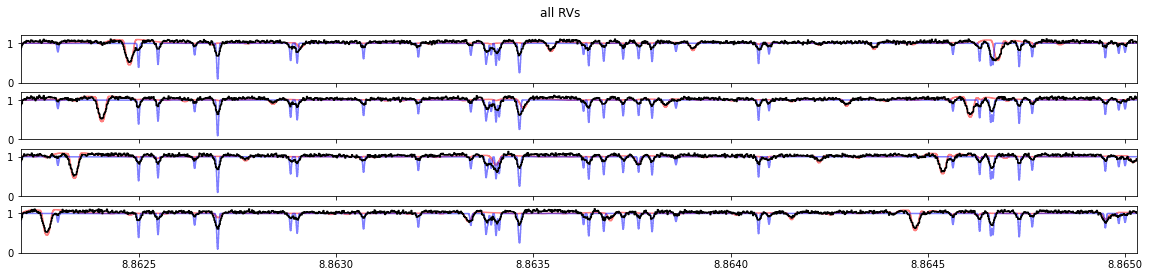

In [11]:
plt_inds = 4
xpmin = np.log(7060)
xpmax = np.log(7080)
fig, axes = plt.subplots(plt_inds,figsize=(20,4),sharex=True,sharey=True)

fig.suptitle('all RVs')
dataset_i = 0
for j in range(plt_inds):        
    axes[j].step(np.log(h5_data[dataset_i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),(normal_flux(h5_data[dataset_i]['theory']['interpolated']['star']['flux'][j,:])),'r',where='mid',alpha=0.5)
    axes[j].step(np.log(h5_data[dataset_i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),(h5_data[dataset_i]['theory']['interpolated']['random']['flux'][j,:]),'b',where='mid',alpha=0.5)
    axes[j].step(np.log(h5_data[dataset_i]['data']['wave'].to(u.Angstrom).value),(normal_flux(h5_data[dataset_i]['data']['flux'][j,:])),'k',where='mid')

    axes[j].set_xlim(xpmin,xpmax)
    axes[j].set_ylim(0.0,1.2)
plt.show() 

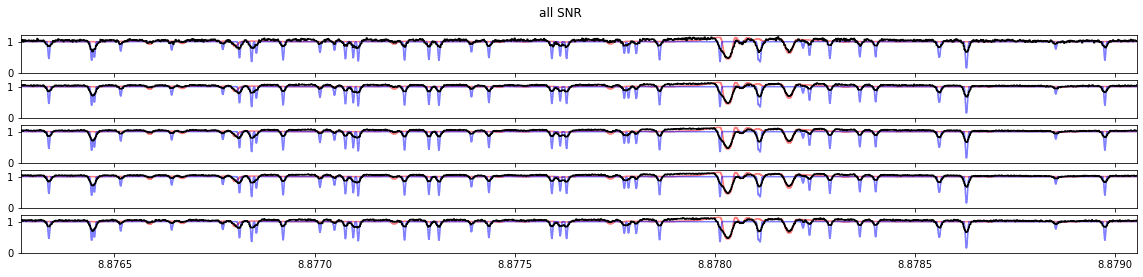

In [12]:
plt_i = 2
xpmin = np.log(7160)
xpmax = np.log(7180)
fig, axes = plt.subplots(len(datasets),figsize=(20,4),sharex=True,sharey=True)

fig.suptitle('all SNR')
for i in range(len(datasets)):       
    axes[i].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),(normal_flux(h5_data[i]['theory']['interpolated']['star']['flux'][plt_i,:])),'r',where='mid',alpha=0.5)
    axes[i].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:]),'b',where='mid',alpha=0.5)
    axes[i].step(np.log(h5_data[i]['data']['wave'].to(u.Angstrom).value),(normal_flux(h5_data[i]['data']['flux'][plt_i,:])),'k',where='mid')

    axes[i].set_xlim(xpmin,xpmax)
    axes[i].set_ylim(0.0,1.2)
plt.show()

<h2>Definitions</h2>
Define our loss function, Chi Square, Models, and Initial Values.

In [13]:
loss = jabble.loss.ChiSquare()
init_vels = np.linspace(-301,301,epoches) * u.km/u.s
# init_vels = rv
init_shifts = jabble.dataset.shifts(init_vels)

In [14]:
vel_padding = 4 * u.km/u.s
x_grid = jabble.model.create_x_grid(dataset.xs,vel_padding,2*resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))

# models = [jabble.model.stellar_model(init_shifts,x_grid) for dataset in datasets]

In [15]:
# for model in models:
#     model.fix()

In [16]:
# models[0][0].fit()
# for model in models:
#     model.display()

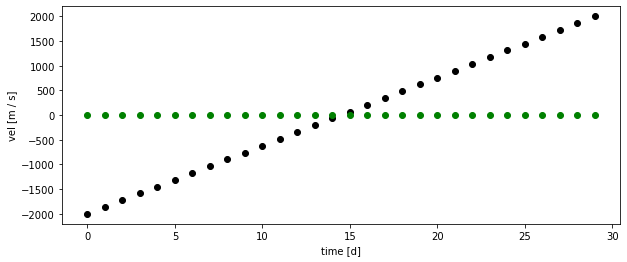

In [17]:
fig = plt.figure(figsize=(10,4))
v_unit = u.m/u.s
plt.plot((rv - init_vels).to(v_unit).value,'ok',label='truth')
plt.plot((init_vels-init_vels).to(v_unit).value,'og',label='truth')

# fig.colorbar(cm.plasma)
for i in range(len(datasets)):
#     final_vels = jabble.dataset.velocities(models[i][0].p)
    
    v_unit = u.m/u.s
#     plt.plot((final_vels - init_vels).to(v_unit).value,'o',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)))
    plt.ylabel('vel [{}]'.format(v_unit))
    plt.xlabel('time [d]')

plt.savefig('../out/velocity_plots.png')
plt.show()

In [18]:
def train_cycle(model,data,loss,fit1_inds):
    model.fix()
    for ind in fit1_inds:
        model.fit(*ind)
    res1 = model.optimize(loss,data,options={'iprint':1,'ftol':1e-23,'maxls':256,'eps':1e-12,'maxiter':128},save_history=True,save_loss=True)
    model.fix()
    return model

<h2>Round 1</h2>
Fit the flux control points to the data using the train cycle described!

<h2>Round 2</h2>
now fitting both the flux control points and red shifts!

In [19]:
print(type(init_shifts))

<class 'astropy.units.quantity.Quantity'>


In [20]:
ind1 = [[1]]
ind2 = [[0],[1]]

final_vels = np.zeros((len(datasets),epoches)) * u.km/u.s

models = [jabble.model.CompositeModel([jabble.model.ShiftingModel(np.array(init_shifts)),jabble.model.JaxLinear(x_grid)]) for data in datasets]
for i in range(len(models)):
    if i > 0:
        print(id(models[i][0].p) == id(models[i-1][0].p))

for i in range(len(datasets)):
    models[i].display()
    models[i] = train_cycle(models[i],datasets[i],loss,ind1)
    models[i].display()
    models[i] = train_cycle(models[i],datasets[i],loss,ind2)

    filename = 'jab_model_snr_{}.model'.format(snrs[i])
    jabble.model.save(os.path.join(outdir,filename),models[i])
    
    final_vels[i,:] = jabble.dataset.velocities(models[i][0].p)

2022-04-11 14:58:06.169914: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs


False
False
False
False
-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-JaxLinear------------------------------------------------------0


2022-04-11 14:58:06.169941: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61145D+07    |proj g|=  1.16823D+05


 This problem is unconstrained.



At iterate    1    f=  1.44974D+07    |proj g|=  1.08598D+05

At iterate    2    f=  8.86776D+06    |proj g|=  3.45061D+04

At iterate    3    f=  8.80614D+06    |proj g|=  1.78637D+04

At iterate    4    f=  8.78815D+06    |proj g|=  7.78067D+03

At iterate    5    f=  8.78278D+06    |proj g|=  6.62956D+03

At iterate    6    f=  8.77817D+06    |proj g|=  5.15120D+03

At iterate    7    f=  8.77536D+06    |proj g|=  4.27684D+03

At iterate    8    f=  8.77346D+06    |proj g|=  2.94118D+03

At iterate    9    f=  8.77296D+06    |proj g|=  2.06429D+03

At iterate   10    f=  8.77259D+06    |proj g|=  1.36297D+03

At iterate   11    f=  8.77249D+06    |proj g|=  2.42070D+03

At iterate   12    f=  8.77234D+06    |proj g|=  1.06340D+03

At iterate   13    f=  8.77230D+06    |proj g|=  1.01015D+03

At iterate   14    f=  8.77224D+06    |proj g|=  8.56383D+02

At iterate   15    f=  8.77216D+06    |proj g|=  5.85995D+02

At iterate   16    f=  8.77214D+06    |proj g|=  1.21942D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.75863D+06    |proj g|=  2.09854D+10

At iterate    1    f=  8.41263D+06    |proj g|=  1.38955D+10

At iterate    2    f=  8.06645D+06    |proj g|=  2.63949D+09

At iterate    3    f=  8.06550D+06    |proj g|=  2.88481D+09

At iterate    4    f=  8.06487D+06    |proj g|=  2.20086D+09

At iterate    5    f=  8.06487D+06    |proj g|=  2.20086D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14485      5     37      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-JaxLinear------------------------------------------------------0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38430D+08    |proj g|=  1.05219D+06


 This problem is unconstrained.



At iterate    1    f=  1.23891D+08    |proj g|=  9.78161D+05

At iterate    2    f=  7.32885D+07    |proj g|=  3.09869D+05

At iterate    3    f=  7.27385D+07    |proj g|=  1.60293D+05

At iterate    4    f=  7.25778D+07    |proj g|=  7.19909D+04

At iterate    5    f=  7.25297D+07    |proj g|=  6.17154D+04

At iterate    6    f=  7.24882D+07    |proj g|=  4.67581D+04

At iterate    7    f=  7.24634D+07    |proj g|=  4.40374D+04

At iterate    8    f=  7.24466D+07    |proj g|=  2.61619D+04

At iterate    9    f=  7.24420D+07    |proj g|=  1.83758D+04

At iterate   10    f=  7.24387D+07    |proj g|=  1.21002D+04

At iterate   11    f=  7.24379D+07    |proj g|=  2.41251D+04

At iterate   12    f=  7.24365D+07    |proj g|=  9.41286D+03

At iterate   13    f=  7.24362D+07    |proj g|=  8.97814D+03

At iterate   14    f=  7.24356D+07    |proj g|=  7.59620D+03

At iterate   15    f=  7.24350D+07    |proj g|=  5.24298D+03

At iterate   16    f=  7.24347D+07    |proj g|=  8.63432D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   23    f=  7.24342D+07    |proj g|=  8.47528D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14455     23     37      1     0     0   8.475D+02   7.243D+07
  F =   72434240.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-JaxLinear------------------------------------------------------0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14485     M =           10

At X0         0 variables are exactly a

 This problem is unconstrained.



At iterate    1    f=  6.90237D+07    |proj g|=  1.24496D+11

At iterate    2    f=  6.59211D+07    |proj g|=  2.49917D+10

At iterate    3    f=  6.59094D+07    |proj g|=  1.95172D+10

At iterate    4    f=  6.59090D+07    |proj g|=  1.95172D+10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f=  6.59090D+07    |proj g|=  1.95172D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14485      5     35      1     0     0   1.952D+10   6.591D+07
  F =   65909000.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-JaxLinear------------------------------------------------------0


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45429D+08    |proj g|=  1.87064D+06

At iterate    1    f=  2.19584D+08    |proj g|=  1.73896D+06

At iterate    2    f=  1.29639D+08    |proj g|=  5.51417D+05

At iterate    3    f=  1.28660D+08    |proj g|=  2.85657D+05

At iterate    4    f=  1.28374D+08    |proj g|=  1.27327D+05

At iterate    5    f=  1.28289D+08    |proj g|=  1.09009D+05

At iterate    6    f=  1.28215D+08    |proj g|=  8.27117D+04

At iterate    7    f=  1.28171D+08    |proj g|=  7.59849D+04

At iterate    8    f=  1.28141D+08    |proj g|=  4.67346D+04

At iterate    9    f=  1.28133D+08    |proj g|=  3.28681D+04

At iterate   10    f=  1.28127D+08    |proj g|=  2.15165D+04

At iterate   11    f=  1.28125D+08    |proj g|=  4.11068D+04

At iterate   12    f=  1.28123D+08    |proj g|=  1.67057D+04

At iterate   13    f=  1.2

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27889D+08    |proj g|=  3.37852D+11

At iterate    1    f=  1.23021D+08    |proj g|=  2.42665D+11

At iterate    2    f=  1.16495D+08    |proj g|=  3.76957D+10

At iterate    3    f=  1.16485D+08    |proj g|=  3.48913D+10

At iterate    4    f=  1.16485D+08    |proj g|=  3.48913D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14485      4     37      1     0     0   3.489D+10   1.165D+08
  F =   116485360.00000000     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-JaxLinear------------------------------------------------------0


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83063D+08    |proj g|=  2.92263D+06

At iterate    1    f=  3.42684D+08    |proj g|=  2.71668D+06

At iterate    2    f=  2.02154D+08    |proj g|=  8.62046D+05

At iterate    3    f=  2.00624D+08    |proj g|=  4.46728D+05

At iterate    4    f=  2.00177D+08    |proj g|=  1.99332D+05

At iterate    5    f=  2.00044D+08    |proj g|=  1.70765D+05

At iterate    6    f=  1.99929D+08    |proj g|=  1.29016D+05

At iterate    7    f=  1.99860D+08    |proj g|=  1.15178D+05

At iterate    8    f=  1.99813D+08    |proj g|=  7.25808D+04

At iterate    9    f=  1.99801D+08    |proj g|=  5.10281D+04

At iterate   10    f=  1.99792D+08    |proj g|=  3.33328D+04

At iterate   11    f=  1.99789D+08    |proj g|=  6.03815D+04

At iterate   12    f=  1.99786D+08    |proj g|=  2.59389D+04

At iterate   13    f=  1.9


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99422D+08    |proj g|=  5.27342D+11


 This problem is unconstrained.



At iterate    1    f=  1.90011D+08    |proj g|=  3.46294D+11

At iterate    2    f=  1.81588D+08    |proj g|=  5.40199D+10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    3    f=  1.81588D+08    |proj g|=  5.40199D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14485      3     36      1     0     0   5.402D+10   1.816D+08
  F =   181588480.00000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-JaxLinear------------------------------------------------------0


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14455     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.19669D+07    |proj g|=  4.67537D+05

At iterate    1    f=  5.55066D+07    |proj g|=  4.34588D+05

At iterate    2    f=  3.30276D+07    |proj g|=  1.38665D+05

At iterate    3    f=  3.27825D+07    |proj g|=  7.21371D+04

At iterate    4    f=  3.27107D+07    |proj g|=  3.18395D+04

At iterate    5    f=  3.26892D+07    |proj g|=  2.72511D+04

At iterate    6    f=  3.26709D+07    |proj g|=  2.07642D+04

At iterate    7    f=  3.26598D+07    |proj g|=  1.84880D+04

At iterate    8    f=  3.26524D+07    |proj g|=  1.16211D+04

At iterate    9    f=  3.26503D+07    |proj g|=  8.18394D+03

At iterate   10    f=  3.26489D+07    |proj g|=  5.24099D+03

At iterate   11    f=  3.26485D+07    |proj g|=  9.52314D+03

At iterate   12    f=  3.26479D+07    |proj g|=  4.06614D+03

At iterate   13    f=  3.2


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14485     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25906D+07    |proj g|=  8.47629D+10

At iterate    1    f=  3.08603D+07    |proj g|=  5.46070D+10

At iterate    2    f=  2.97467D+07    |proj g|=  7.73763D+09

At iterate    3    f=  2.97467D+07    |proj g|=  7.73763D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14485      3     32      1     0     0   7.738D+09   2.975D+07
  F =   29746700.000000000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [21]:
print(models[0].func_evals[-1],models[0].results[1].fun,loss.loss_all(models[0].get_parameters(),datasets[0],models[0]))

8064870.5 8064870.5 8064063.5


In [22]:
print("res", models[0].func_evals[-1],models[0].results[1].fun)
models[0].fix()
models[0].display()
a = models[0][0].p
print(loss([],datasets[0],0,models[0]).sum())
print(loss.loss_all([],datasets[0],models[0]))

models[0].fit(0)
models[0].display()
b = models[0].get_parameters()
print(a == b)
print(loss(b,datasets[0],0,models[0]).sum())
print(loss.loss_all(b,datasets[0],models[0]))


models[0].fix()
models[0].fit(0)
models[0].fit(1)
models[0].display()
b = models[0].get_parameters()
print(loss(b,datasets[0],0,models[0]).sum())
print(loss.loss_all(b,datasets[0],models[0]))

models[0].fix()
models[0].fit(1)
models[0].display()
b = models[0].get_parameters()
print(loss(b,datasets[0],0,models[0]).sum())
print(loss.loss_all(b,datasets[0],models[0]))

res 8064870.5 8064870.5
-CompositeModel----------------------------------------------------0
  0-ShiftingModel--------------------------------------------------0
  1-JaxLinear------------------------------------------------------0
271316.75
8064063.5
-CompositeModel---------------------------------------------------30
  0-ShiftingModel-------------------------------------------------30
  1-JaxLinear------------------------------------------------------0
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
271579.34
8064870.5
-CompositeModel------------------------------------------------14485
  0-ShiftingModel-------------------------------------------------30
  1-JaxLinear--------------------------------------------------14455
271579.34
8064870.5
-CompositeModel------------------------------------------------14455
  0-ShiftingModel-------------------------

In [23]:
import cProfile

In [24]:
# cProfile.run("loss(b,datasets[0],0,models[0]).sum()")

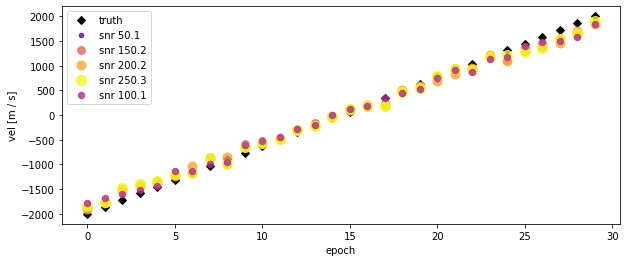

In [25]:
fig = plt.figure(figsize=(10,4),facecolor=(1,1,1))
v_unit = u.m/u.s
plt.plot((rv - init_vels).to(v_unit).value,'Dk',label='truth')
for i in range(len(datasets)):
    
    vmean  = np.mean(final_vels[i,:])
    v_unit = u.m/u.s
    plt.plot((final_vels[i,:] - vmean - init_vels).to(v_unit).value,'o',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.8,markersize=10*(snrs[i]/max(snrs))**(1/2))
    plt.ylabel('vel [{}]'.format(v_unit))
    plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(outdir,'rvs_s_min_init.png'),dpi=300)
plt.show()

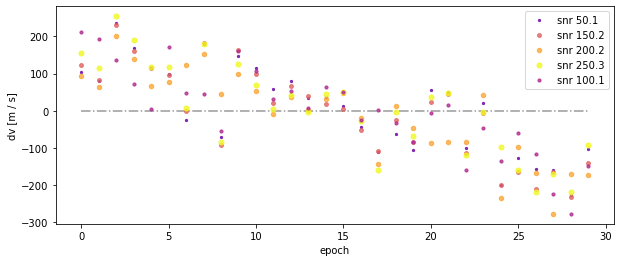

In [26]:
fig = plt.figure(figsize=(10,4),facecolor=(1,1,1))
v_unit = u.m/u.s

plt.plot(np.zeros((30)),'-.k',alpha=0.4)
# fig.colorbar(cm.plasma)
for i in range(len(datasets)):
#     print((snrs[i]/max(snrs))**(1/2))
    v_unit = u.m/u.s
    plt.plot((final_vels[i,:] - vmean - rv).to(v_unit).value,'.',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.8,markersize=10 * (snrs[i]/max(snrs))**(1/2))
plt.ylabel('dv [{}]'.format(v_unit))
plt.xlabel('epoch')
# plt.ylim(-150,150)
plt.legend()
plt.savefig(os.path.join(outdir,'rvs_s_min_rvs.png'),dpi=300)
plt.show()

<h2>Plotting Hours</h2>
Oh yea it's plottin' time

In [27]:
%matplotlib notebook

In [28]:
# for x in models[0].loss_history:
#     print(x.shape)

In [29]:
models[0].fix()
models[0].fit(0)
b = models[0].get_parameters()
print(b.shape)

(30,)


[40, 36]
76
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


<IPython.core.display.Javascript object>


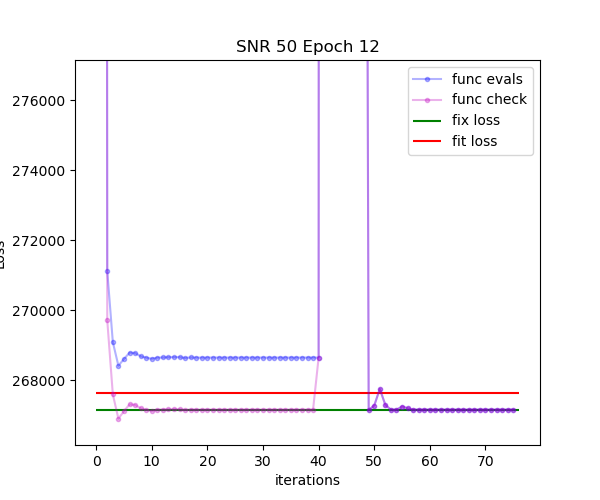

267646.6 267160.94 267150.1552633202 267160.93327574874 49
267150.1552633202


In [44]:
plt_i = 12
mdl_i = 0

iter_num = [xl.nfev for xl in models[mdl_i].results]
print(iter_num)
print(len(models[mdl_i].history))

models[mdl_i].fix()
models[mdl_i].fit(1)
loss_check = []
for i,params in enumerate(models[mdl_i].history):
    if i > iter_num[0]-1:
        models[mdl_i].fit(0)
    loss_check.append(loss(params,datasets[mdl_i],plt_i,models[mdl_i]).sum())

models[mdl_i].fix()
a = models[mdl_i][0].p
fix_loss = loss([],datasets[mdl_i],plt_i,models[mdl_i]).sum()

print(a == b)
models[mdl_i].fit(0)
b = models[mdl_i].get_parameters()
fitting_loss = loss(b,datasets[mdl_i],plt_i,models[mdl_i]).sum()

plt.figure(figsize=(6,5))

loss_total = [xl[plt_i,:].sum() for xl in models[mdl_i].loss_history]

print(fitting_loss, fix_loss, min(loss_total), loss_total[-1], np.argmin(loss_total))

plt.plot(loss_total,'.-b',alpha=0.3,label='func evals')
plt.plot(loss_check,'.-m',alpha=0.3,label='func check')

plt.hlines(fix_loss,0,len(models[mdl_i].func_evals),['g'],label='fix loss')
plt.hlines(fitting_loss,0,len(models[mdl_i].func_evals),['r'],label='fit loss')
plt.ylim(min(loss_total)-1e3,min(loss_total)+1e4)
print(min(loss_total))
# plt.xlim(len(models[mdl_i].func_evals) - 45, len(models[mdl_i].func_evals))
plt.title('SNR {:2.0f} Epoch {}'.format(snrs[mdl_i], plt_i))
plt.ylabel('Loss')
plt.xlabel('iterations')
plt.legend()
plt.show()

note that the func check does not match the func eval. in the first training cycle, this is because it is using the final velocity that it has saved and not the og init vel which exaplins why it is very close to the final loss value.

<IPython.core.display.Javascript object>


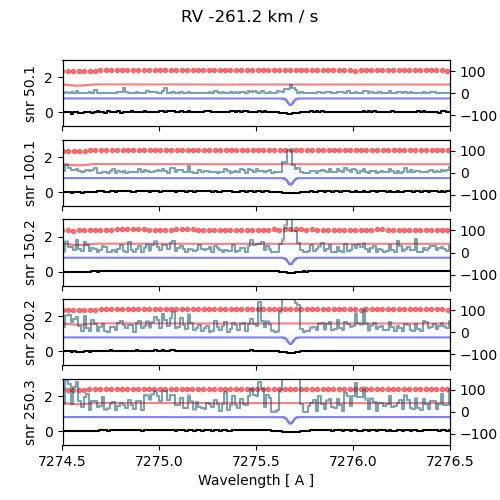

/state/partition1/job-17700048/ipykernel_2125303/2625365119.py:21: RuntimeWarning: invalid value encountered in log
  axes[index].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:]) + 1. * plot_shift,'b',where='mid',alpha=0.5,label='tellurics theory')
/state/partition1/job-17700048/ipykernel_2125303/2625365119.py:21: RuntimeWarning: invalid value encountered in log
  axes[index].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:]) + 1. * plot_shift,'b',where='mid',alpha=0.5,label='tellurics theory')


271579.34
271316.75
996510.3
996639.8


/state/partition1/job-17700048/ipykernel_2125303/2625365119.py:21: RuntimeWarning: invalid value encountered in log
  axes[index].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:]) + 1. * plot_shift,'b',where='mid',alpha=0.5,label='tellurics theory')
/state/partition1/job-17700048/ipykernel_2125303/2625365119.py:21: RuntimeWarning: invalid value encountered in log
  axes[index].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:]) + 1. * plot_shift,'b',where='mid',alpha=0.5,label='tellurics theory')


2208519.0
2206964.8
3901984.5
3898680.5


/state/partition1/job-17700048/ipykernel_2125303/2625365119.py:21: RuntimeWarning: invalid value encountered in log
  axes[index].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:]) + 1. * plot_shift,'b',where='mid',alpha=0.5,label='tellurics theory')


6092198.0
6089539.5


In [31]:
plt_i = 2
xpmin = np.log(7274.5)
xpmax = np.log(7276.5)
fig, axes = plt.subplots(len(datasets),figsize=(5,5),sharex=True,sharey=True,facecolor=(1,1,1))

tick_min = np.min(datasets[0].xs[0,:])
tick_max = np.max(datasets[0].xs[0,:])
tick_length = 0.5
xlabels = np.arange(tick_length * round(np.exp(tick_min)/tick_length),tick_length * round(np.exp(tick_max)/tick_length),step=tick_length)
xtxpos  = np.log(xlabels)
plt.xticks(xtxpos,xlabels)
plt.xlabel('Wavelength [ A ]')

plot_shift = 0.8

fig.suptitle('RV {:2.1f}'.format(rv[plt_i]))
indices = np.argsort(snrs)
for index,i in enumerate(indices):
#     i = index
    axes[index].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(normal_flux(h5_data[i]['theory']['interpolated']['star']['flux'][plt_i,:]))+ 2 * plot_shift,'r',where='mid',alpha=0.5,label='stellar theory')
    axes[index].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:]) + 1. * plot_shift,'b',where='mid',alpha=0.5,label='tellurics theory')
    axes[index].step(datasets[i].xs[plt_i,:],datasets[i].ys[plt_i,:],'k',where='mid',label='data')
    axes[index].plot(models[i][1].xs-models[i][0].p[plt_i],models[i][1].p + 3 * plot_shift,'.r',zorder=2,alpha=0.5,ms=6,label='stellar model')
    axes[index].set_xlim(xpmin,xpmax)
    axes[index].set_ylim(-0.8,3.)
    axes[index].set_ylabel('snr {:2.1f}'.format(snrs[i]))
    
    
    res_ax = axes[index].twinx()
#     residual = ((datasets[i].ys[plt_i,:] - models[i](models[i].get_parameters(),datasets[i].xs[plt_i,:],i))) * np.sqrt(datasets[i].yivar[plt_i,:])
#     res_ax.step(datasets[i].xs[plt_i,:],residual,where='mid',alpha=0.3,label='residual')
    models[i].fit(0)
    b = models[i].get_parameters()
    res_ax.step(datasets[i].xs[plt_i,:],loss(b,datasets[i],0,models[i]),'blue',where='mid',alpha=0.3,label='residual')
    print(loss(b,datasets[i],0,models[i]).sum())
    models[i].fix()
    a = models[i][0].p
    print(loss([],datasets[i],0,models[i]).sum())
    res_ax.step(datasets[i].xs[plt_i,:],loss([],datasets[i],0,models[i]),'green',where='mid',alpha=0.3,label='residual')
#     res_ax.step(datasets[i].xs[plt_i,:],models[i].loss_history[-2][plt_i,:],'red',where='mid',alpha=0.3,label='residual')
    
    
    res_ax.set_xlim(xpmin,xpmax)
    res_ax.set_ylim(-1.5e2,1.5e2)
handles, labels = axes[0].get_legend_handles_labels()
res_handles, res_labels = res_ax.get_legend_handles_labels()
for i,hand in enumerate(res_handles):
    handles.append(hand)
    labels.append(res_labels[i])
# fig.legend(handles, labels)
plt.savefig(os.path.join(outdir,'flux_s_snrs_x{:2.1f}-{:2.1f}.png'.format(xpmin,xpmax)),dpi=300)
plt.show()

In [32]:
# plt_inds = 4
# xpmin = np.log(7575)
# xpmax = np.log(7580)
# fig, axes = plt.subplots(plt_inds,figsize=(10,10),sharex=True,sharey=True,facecolor=(1,1,1))

# dataset_i = 1
# fig.suptitle('SNR {:2.1f}'.format(snrs[dataset_i]))
# for j in range(plt_inds):        
#     axes[j].step(np.log(h5_data[dataset_i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(normal_flux(h5_data[dataset_i]['theory']['interpolated']['star']['flux'][j,:])),'r',where='mid',alpha=0.5,label='stellar theory')
#     axes[j].step(np.log(h5_data[dataset_i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value),np.log(h5_data[dataset_i]['theory']['interpolated']['random']['flux'][j,:]) + 3.,'b',where='mid',alpha=0.5,label='tellurics theory')
#     axes[j].step(datasets[dataset_i].xs[j,:],datasets[i].ys[j,:] + 1.,'k',where='mid',label='data')
#     axes[j].plot(models[dataset_i][1].xs-models[dataset_i][0].p[j] + 2.,models[dataset_i][1].p,'.r',zorder=2,alpha=0.5,ms=6,label='stellar model')
    
#     axes[j].set_xlim(xpmin,xpmax)
#     axes[j].set_ylim(-1.2,5)
#     axes[j].set_ylabel('RV {:1.0f}'.format(rv[j]))
    
#     res_ax = axes[j].twinx()
# #     residual = ((datasets[i].ys[plt_i,:] - models[i](models[i].get_parameters(),datasets[i].xs[plt_i,:],i))) * np.sqrt(datasets[i].yivar[plt_i,:])
#     res_ax.step(datasets[dataset_i].xs[j,:],residual,where='mid',alpha=0.2,label='residual')
#     res_ax.set_xlim(xpmin,xpmax)
#     res_ax.set_ylim(-1e2,1e2)
# handles, labels = axes[0].get_legend_handles_labels()
# res_handles, res_labels = res_ax.get_legend_handles_labels()
# handles.append(*res_handles)
# labels.append(*res_labels)
# fig.legend(handles, labels)
    
# plt.savefig(os.path.join(outdir,'flux_s_rvs_x{:2.1f}-{:2.1f}.png'.format(xpmin,xpmax)),dpi=300)
# plt.show() 

In [33]:
for i in range(len(datasets)):
#     print(jabble.dataset.velocities(models[i][0].p)[0])''
    if i >0:
        print(id(models[i][0].p) == id(models[i-1][0].p))

False
False
False
False


<IPython.core.display.Javascript object>


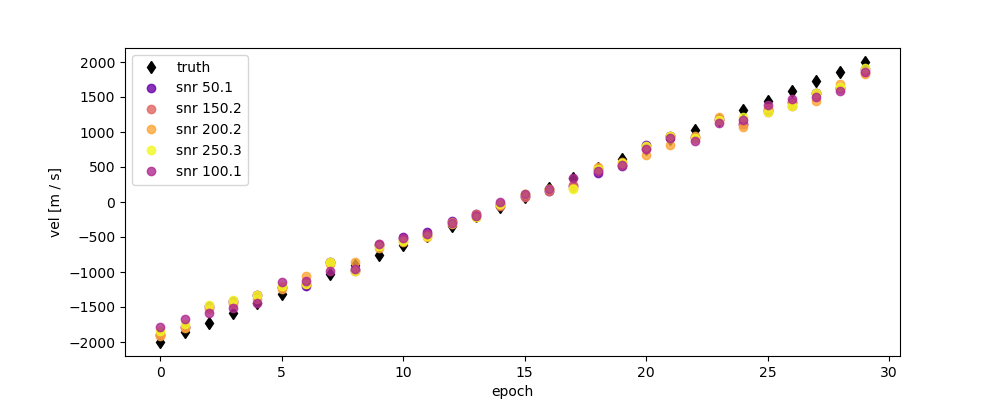

In [34]:
fig = plt.figure(figsize=(10,4),facecolor=(1,1,1))
v_unit = u.m/u.s
plt.plot((rv - init_vels).to(v_unit).value,'dk',label='truth')
# plt.plot((init_vels-init_vels).to(v_unit).value,'og',label='init')

# fig.colorbar(cm.plasma)
for i in range(len(datasets)):
    final_vels = jabble.dataset.velocities(models[i][0].p)
    
    v_unit = u.m/u.s
    plt.plot((final_vels - init_vels).to(v_unit).value,'o',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.8)
    plt.ylabel('vel [{}]'.format(v_unit))
    plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(outdir,'rvs_s_min_init.png'),dpi=300)
plt.show()

In [35]:
# fig = plt.figure(figsize=(10,4),facecolor=(1,1,1))
# v_unit = u.m/u.s

# # fig.colorbar(cm.plasma)
# for i in range(len(datasets)):
# #     final_vels = jabble.dataset.velocities(models[i][0].p)
#     print(final_vels[0])
#     v_unit = u.m/u.s
#     plt.plot((final_vels - rv).to(v_unit).value,'.',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.8,markersize=20*(snrs[i]/max(snrs)))
#     plt.ylabel('dv [{}]'.format(v_unit))
#     plt.xlabel('epoch')
# plt.legend()
# plt.savefig(os.path.join(outdir,'rvs_s_min_rvs.png'),dpi=300)
# plt.show()

In [36]:
# fig = plt.figure(figsize=(10,4))
# v_unit = u.m/u.s
# # plt.plot((rv - init_vels).to(v_unit).value,'ok',label='truth')
# # plt.plot((init_vels-init_vels).to(v_unit).value,'og',label='truth')

# # fig.colorbar(cm.plasma)
# for i in range(len(datasets)):
#     final_vels = jabble.dataset.velocities(models[i][0].p)
    
#     v_unit = u.m/u.s
#     plt.plot(abs((final_vels - rv)/rv),'.',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)),alpha=0.8)
#     plt.ylabel('frac res'.format(v_unit))
#     plt.xlabel('epoch')
# plt.legend()
# # plt.savefig(os.path.join(outdir,'rvs_s_min_init.png'))
# plt.show()

In [37]:
for model in models:
    print(model.results)

[      fun: array(8772084.)
 hess_inv: <14455x14455 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., ..., 0., 0., 0.])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 40
      nit: 21
     njev: 40
   status: 0
  success: True
        x: array([0., 0., 0., ..., 0., 0., 0.]),       fun: array(8064870.5)
 hess_inv: <14485x14485 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.51947059e+09, 9.61040576e+08, 4.87146368e+08, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 5
     njev: 36
   status: 0
  success: True
        x: array([-0.00101035, -0.00094073, -0.00087051, ...,  0.        ,
        0.        ,  0.        ])]
[      fun: array(72434240.)
 hess_inv: <14455x14455 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., ..., 0., 0., 0.])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 37
   

In [38]:
import cv2

ImportError: libGL.so.1: cannot open shared object file: No such file or directory

In [ ]:
def sliding_video(datasets,models,snrs,h5_data,padding,frames,filename,file_format='XVID',fps=24,velocity=1,tick_length = 2.,start_wavelength=None):
    import cv2 as cv
    import matplotlib.pyplot as plt
    import time
    import datetime
    
    fig, axes = plt.subplots(len(datasets),figsize=(10,10),sharex=True,sharey=True,facecolor=(1,1,1))
    
    
    plot_shift = 0.8

    fig.suptitle('RV {:2.1f}'.format(rv[plt_i]))
    indices = np.argsort(snrs).astype(int)
    snrs = [snrs[i] for i in indices]
    datasets = [datasets[i] for i in indices]
    h5_data = [h5_data[i] for i in indices]
    models = [models[i] for i in indices]
    lines = {}
    
     # Angstroms
    
        
    tick_min = np.min(datasets[0].xs[0,:])
    tick_max = np.max(datasets[0].xs[0,:])
    if start_wavelength is None:
        plot_min = tick_min
    else:
        plot_min = np.log(start_wavelength)
    xlabels = np.arange(tick_length * round(np.exp(tick_min)/tick_length),tick_length * round(np.exp(tick_max)/tick_length),step=tick_length)
    xtxpos  = np.log(xlabels)
    plt.xticks(xtxpos,xlabels)
    plt.yticks([])
    plt.xlabel('Wavelength [ A ]')
    residuals = []
    for i in range(len(datasets)):
        key = 'snr {:2.1f}'.format(snrs[i])
        max_val = plot_min + padding
        min_val = plot_min - padding
        lines[key] = {}
        mask_the = (np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value < max_val))
        mask_the = mask_the.astype(bool)
        lines[key]['star'] = axes[i].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value[mask_the]),np.log(normal_flux(h5_data[i]['theory']['interpolated']['star']['flux'][plt_i,:]))[mask_the]+ 2 * plot_shift,'r',where='mid',alpha=0.5,label='stellar theory')[0]
        lines[key]['tellurics'] = axes[i].step(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value[mask_the]),np.log(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:])[mask_the] + 1. * plot_shift,'b',where='mid',alpha=0.5,label='tellurics theory')[0]
        mask_data = (datasets[i].xs[plt_i,:] < max_val)
        mask_data = mask_data.astype(bool)
        lines[key]['data'] = axes[i].step(datasets[i].xs[plt_i,mask_data],datasets[i].ys[plt_i,mask_data],'k',where='mid',label='data')[0]
        mask_model = (models[i][1].xs-models[i][0].p[plt_i] < max_val)
        mask_model = mask_model.astype(bool)
        lines[key]['model'] = axes[i].plot((models[i][1].xs-models[i][0].p[plt_i])[mask_model],models[i][1].p[mask_model] + 3 * plot_shift,'.r',zorder=2,alpha=0.5,ms=6,label='stellar model')[0]
        axes[i].set_xlim(min_val,max_val)
        axes[i].set_ylim(-0.8,3.)
        axes[i].set_ylabel('snr {:2.1f}'.format(snrs[i]))

        res_ax = axes[i].twinx()
        residual = ((datasets[i].ys[plt_i,:] - models[i](models[i].get_parameters(),datasets[i].xs[plt_i,:],i))) * np.sqrt(datasets[i].yivar[plt_i,:])
        residuals.append(residual)
        lines[key]['residual'] = res_ax.step(datasets[i].xs[plt_i,mask_data],residual[mask_data],where='mid',alpha=0.3,label='residual')[0]
        res_ax.set_xlim(min_val,max_val)
        res_ax.set_ylim(-1e2,1e2)
    handles, labels = axes[0].get_legend_handles_labels()
    res_handles, res_labels = res_ax.get_legend_handles_labels()
    handles.append(*res_handles)
    labels.append(*res_labels)
    fig.legend(handles, labels)

    
    ############################
    
    shape = fig.canvas.get_width_height()[::-1]
#     print(shape)
    fourcc = cv.VideoWriter_fourcc(*file_format)
    video = cv.VideoWriter(filename,fourcc,fps=fps,\
                            frameSize=(shape[0],shape[1]))

    
    vel_x = velocity / plot_min
    dx = vel_x/fps
    
    print("saving...")
    dt_avg = 0.0
    est_time = 0.0
    for j in range(frames):
        print('[ {} / {} ] - {}'.format(j,frames,str(datetime.timedelta(seconds=est_time))))
        # REDRAW ALL LINES
        time_start = time.time()
        for i,key in enumerate(lines.keys()):
            max_val = (dx*j) + padding + plot_min
            min_val = (dx*j) - padding + plot_min
            mask_the = (np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value) < max_val) * (np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value) > min_val)
            mask_the = mask_the.astype(bool)
            lines[key]['star'].set_xdata(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value[mask_the]))
            lines[key]['star'].set_ydata(np.log(normal_flux(h5_data[i]['theory']['interpolated']['star']['flux'][plt_i,:]))[mask_the] + 2 * plot_shift)

            lines[key]['tellurics'].set_xdata(np.log(h5_data[i]['theory']['interpolated']['total']['wave'].to(u.Angstrom).value[mask_the]))
            lines[key]['tellurics'].set_ydata(np.log(h5_data[i]['theory']['interpolated']['random']['flux'][plt_i,:])[mask_the] + 1. * plot_shift)
             
            
            mask_data = (datasets[i].xs[plt_i,:] < max_val) * (datasets[i].xs[plt_i,:] > min_val)
            mask_data = mask_data.astype(bool)
            lines[key]['data'].set_xdata(datasets[i].xs[plt_i,mask_data])
            lines[key]['data'].set_ydata(datasets[i].ys[plt_i,mask_data])
            # mask model
            mask_model = (models[i][1].xs-models[i][0].p[plt_i] < max_val) * (models[i][1].xs-models[i][0].p[plt_i] > min_val)
            mask_model = mask_model.astype(bool)
            lines[key]['model'].set_xdata((models[i][1].xs-models[i][0].p[plt_i])[mask_model])
            lines[key]['model'].set_ydata(models[i][1].p[mask_model] + 3 * plot_shift)
            axes[i].set_xlim(min_val,max_val)

            lines[key]['residual'].set_xdata(datasets[i].xs[plt_i,mask_data])
            lines[key]['residual'].set_ydata(residuals[i][mask_data])
            res_ax.set_xlim(min_val,max_val)                        
                          
        ###############################################

        # redraw the canvas
        fig.canvas.draw()

        # convert canvas to image
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        # img is rgb, convert to opencv's default bgr
        img = cv.cvtColor(img,cv.COLOR_RGB2BGR)
    
        time_end = time.time()
        dt = time_end - time_start
        dt_avg *= j/(j+1)
        dt_avg += dt / (j+1)
        est_time = dt_avg * (frames-j-1)
        video.write(img)

    cv.destroyAllWindows()
    video.release()
    print("saved to {}".format(filename))

In [ ]:
start_wavelength = np.exp(np.min(models[0][1].xs))
velocity = 0.0009
frames = 120
fps = 24
start_wavelength = 7010
padding = np.log(8104)-np.log(8100)
filename = os.path.join(outdir,'wobble_vid_fps{:2.0f}_w{:2.1f}_v{:2.0f}_pd{:2.1f}.mp4'.format(fps,start_wavelength,velocity,padding))
sliding_video(datasets,models,snrs,h5_data,padding,frames=frames,filename=filename,file_format='MP4V',fps=fps,velocity=velocity,start_wavelength=start_wavelength)

In [ ]:
print(filename)

In [ ]:
Video(filename,width=720,embed=True)